# Grover's algorithm

For this Qiskit in Classrooms module, students must have a working Python environment with the following packages installed:
- `qiskit` v2.1.0 or newer
- `qiskit-ibm-runtime` v0.40.1 or newer
- `qiskit-aer` v0.17.0 or newer
- `qiskit.visualization`
- `numpy`
- `pylatexenc`

To set up and install the packages above, see the [Install Qiskit](/docs/guides/install-qiskit) guide.
In order to run jobs on real quantum computers, students will need to set up an account with IBM Quantum&reg; by following the steps in the [Set up your IBM Cloud account](/docs/guides/cloud-setup) guide.

This module was tested and used 12 sec. of QPU time. This is a good-faith estimate; your actual usage may vary.

In [ ]:
# Uncomment and modify this line as needed to install dependencies
#!pip install 'qiskit>=2.1.0' 'qiskit-ibm-runtime>=0.40.1' 'qiskit-aer>=0.17.0' 'numpy' 'pylatexenc'

## Introduction

**Grover's algorithm** is a foundational quantum algorithm that addresses the *unstructured search problem*: given a set of $N$ items and a way to check if any given item is the one you're looking for, how quickly can you find the desired item? In classical computing, if the data is unsorted and there is no structure to exploit, the best approach is to check each item one by one, leading to a query complexity of $O(N)$—on average, you'll need to check about half the items before finding the target.


![A diagram of classical unstructured search.](/learning/images/modules/computer-science/grovers/classical-uss.avif)

Grover's algorithm, introduced by Lov Grover in 1996, demonstrates how a quantum computer can solve this problem much more efficiently, requiring only $O(\sqrt{N})$ steps to find the marked item with high probability. This represents a *quadratic speedup* over classical methods, which is significant for large datasets.

The algorithm operates in the following context:
- **Problem setup:** You have a function $f(x)$ that returns 1 if $x$ is the item you want, and 0 otherwise. This function is often called an *oracle* or *black box*, since you can only learn about the data by querying $f(x)$.
- **Usefulness of quantum:** While classical algorithms for this problem require, on average, $N/2$ queries, Grover's algorithm can find the solution in roughly $\pi\sqrt{N}/4$ queries, which is much faster for large $N$.
- **How it works (at a high level):**
  - The quantum computer first creates a *superposition* of all possible states, representing all possible items at once.
  - It then repeatedly applies a sequence of quantum operations (the Grover iteration) that amplifies the probability of the correct answer and diminishes the others.
  - After enough iterations, measuring the quantum state yields the correct answer with high probability.

Here is a very basic diagram of Grover's algorithm that skips over a lot of nuance. For a more detailed diagram see [this paper](https://arxiv.org/pdf/2211.04543).

![A high-level diagram of the steps in implementing Grover's algorithm.](/learning/images/modules/computer-science/grovers/quantum-uss.avif)

A few things to note about Grover's algorithm:
- It is optimal for unstructured search: no quantum algorithm can solve the problem with fewer than $O(\sqrt{N})$ queries.
- It provides only a quadratic, not exponential, speedup—unlike some other quantum algorithms (e.g., Shor's algorithm for factoring).
- It has practical implications, such as potentially speeding up brute-force attacks on cryptographic systems, though the speedup is not enough to break most modern encryption by itself.

For undergraduate students familiar with basic computing concepts and query models, Grover's algorithm offers a clear illustration of how quantum computing can outperform classical approaches for certain problems, even when the improvement is "only" quadratic. It also serves as a gateway to understanding more advanced quantum algorithms and the broader potential of quantum computing.

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. The runtime `Sampler` primitive allows seamless execution of Grover circuits.

## Math
Suppose there exists a function $f$ that maps binary strings to a single binary variable, meaning
$$
f: \Sigma^n \rightarrow \Sigma
$$
One example defined on $\Sigma^6$ is
$$
f(x)= \begin{cases} 1 \qquad \text{if }x=\{010101\}\\
0 \qquad \text{otherwise }
\end{cases}
$$
Another example defined on $\Sigma^{2n}$ is
$$
f(x)= \begin{cases} 1 \qquad \text{if equal numbers of 1's and 0's in string}\\
0 \qquad \text{otherwise }
\end{cases}
$$
You are tasked with finding quantum states corresponding to those arguments $x$ of $f(x)$ that are mapped to 1. In other words, find all $\{x_1\}\in \Sigma^n$ such that $f(x_1)=1$ (or if there is no solution, report that). We would refer to non-solutions as $x_0$. Of course, we will do this on a quantum computer, using quantum states, so it is useful to express these binary strings as states:
$$
\{|x_1\rangle\} \in |\Sigma^n\rangle
$$
Using the quantum state (Dirac) notation, we are looking for one or more special states $\{|x_1\rangle\}$ in a set of $N=2^n$ possible states, where $n$ is the number of qubits, and with non-solutions denoted $\{|x_0\rangle\}.$

We can think of the function $f$ as being provided by an oracle: a black-box that we can query to determine its effect on a state $|x\rangle.$ In practice, we will often know the function, but it may be very complicated to implement, meaning that reducing the number of queries or applications of $f$ could be important. Alternatively, we can imagine a paradigm in which one person is querying an oracle controlled by another person, such that we don't know the oracle function, we only know its action on particular states from querying.

This is an "unstructured search problem, in that there is nothing special about $f$ that aids us in our search. The outputs are not sorted nor are solutions known to cluster, and so on. Consider use old, paper phone books as an analogy. This unstructured search would be like scanning through it looking for a certain __number__, and not like looking through an alphabetized list of names.

In the case where a single solution is sought, classically, this requires a number of queries that is linear in $N$. Clearly you might find a solution on the first try, or you might find no solutions in the first $N-1$ guesses, such that you need to query the $N^{th}$ input to see if there is any solution at all. Since the functions have no exploitable structure, you will require $N/2$ guesses on average. Grover's algorithm requires a number of queries or computations of $f$ that scales like $\sqrt{N}.$

## Sketch of circuits in Grover's algorithm

A full mathematical walkthrough of Grover's algorithm can be found, for example, in Fundamentals of Quantum Algorithms, a course by John Watrous on IBM Quantum Learning. A condensed treatment is provided in an appendix at the end of this module. But for now, we will only review the overall structure of the quantum circuit that implements Grover's algorithm.

Grover's algorithm can be broken down into the following stages
* Preparation of an initial superposition (applying Hadamard gates to all qubits)
* "Marking" the target state(s) with a phase flip
* A "diffusion" stage in which Hadamard gates and a phase flip are applied to __all__ qubits.
* Possible repeitions of the marking and diffusion stages to maximize the probability of measuring the target state.
* Measurement

![A quantum circuit diagram showing the basic setup of Grover's algorithm. This example uses four qubits.](/learning/images/modules/computer-science/grovers/grover-circuit-diagram-2.avif)

Often, the marking gate $Z_f$ and the diffusion layers consisting of $H,$ $Z_{\text{OR}},$ and $H$ are collectively referred to as the "Grover operator". In this diagram, only a single repetition of the Grover operator is shown.

Hadamard gates $H$ are well-known and used widely throughout quantum computing. The Hadamard gate creates superposition states. Specifically it is defined by
$$
H|0\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)\\
H|1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle-|1\rangle\right)
$$
And its operation on any other state is defined through linearity.
In particularly, a layer of Hadamard gates allows us to go from the initial state with all qubits in $|0\rangle$ (denoted $|0\rangle^{\otimes n}$) to a state where each qubit has some probability of being measured in either $|0\rangle$ or $|1\rangle;$ this lets us probe the space of all possible states differently from in classical computing.

An important corollary property of the Hadamard gate is that acting a second time can undo such superposition states:
$$
H\frac{1}{\sqrt{2}}\left(|0\rangle+|1\rangle\right)=|0\rangle\\
H\frac{1}{\sqrt{2}}\left(|0\rangle-|1\rangle\right)=|1\rangle
$$

This will be important in just a moment.

#### Check your understanding
Read the question below, think about your answer, then click the triangle to reveal the solution.

<details>
<summary>

Starting from the definition of the Hadamard gate, demonstrate that a second application of the Hadamard gate undoes such superpositions as claimed above.

</summary>

__Answer:__

When we apply X to the $|+\rangle$ state, we get the value and +1 and to the state $|-\rangle$ we get -1, so if we had a 50-50 distribution, we would get an expectation value of 0.

</details>

The $Z_\text{OR}$ gate is less common, and is defined according to
$$
\text{Z}_\text{OR}|x\rangle = \begin{cases}
|x\rangle & \text{if } x = 0^n \\
    -|x\rangle  & \text{if } x \neq 0^n
\end{cases}
\qquad \forall x \in \Sigma^n
$$

Finally, the $Z_f$ gate is defined by
$$
Z_f:|x\rangle \rightarrow (-1)^{f(x)}|x\rangle \qquad \forall x \in \Sigma^n
$$

Note the effect of this is that $Z_f$ flips the sign on a target state for which $f(x) = 1$ and leaves other states unaffected.

At a very high, hand-wavy level you can think about the steps in the circuit in the following ways:
* First Hadamard layer: puts the qubits into a superposition of all possible states.
* $Z_f$: mark the target state(s) by adding a "-" sign in front. This doesn't immediately change measurement probabilities, but it changes how the target state will behave in subsequent steps.
* Another Hadamard layer: The "-" sign introduced in the previous step will change the relative sign between some terms. Since Hadamard gates turn one mixture of computational states $(|0\rangle+|1\rangle)/\sqrt{2}$ into one computational state, $|0\rangle,$ and they turn $(|0\rangle-|1\rangle)/\sqrt{2}$ into $|1\rangle$ this relative sign difference can now begin to play a role in what states are measured.
* One final layer of Hadamard gates is applied, and then measurements are made.
We will see in more detail how this works in the next section.

### Example
To better understand how Grover's algorithm works, let us work through a small, two-qubit example. This may be considered optional for those not focused on quantum mechanics and Dirac notation. But for those who hope to work substantially with quantum computers, this is highly recommended.

Here is the circuit diagram with the quantum states labeled at various positions throughout. Note that with only two qubits, there are only four possible states that could be measured under any circumstances: $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$.

![A diagram of a quantum circuit that implements Grover's algorithm on two qubits.](/learning/images/modules/computer-science/grovers/grover-circuit-diagram-2-q-ex.avif)

Let us suppose that the oracle ($Z_f$, unknown to us) marks the state $|01\rangle$. We will work through the actions of each set of quantum gates, including the oracle, and see what distribution of possible states come out at the time of measurement.
At the very beginning, we have
$$
|\psi_0\rangle = |00\rangle
$$
Using the definition of Hadamard gates, we have
$$
|\psi_1\rangle = \frac{1}{2}\left(|0\rangle+|1\rangle\right)\left(|0\rangle+|1\rangle\right)=\frac{1}{2}\left(|00\rangle+|01\rangle+|10\rangle+|11\rangle\right)
$$
Now the oracle marks the target state:
$$
|\psi_2\rangle = \frac{1}{2}\left(|00\rangle-|01\rangle+|10\rangle+|11\rangle\right)
$$
Note that in this state, all four possible outcomes have the same probability of being measured. They all have a weight of magnitude $1/2,$ meaning they each have a $|1/2|^2=1/4$ chance of being measured. So while the state $|01\rangle$ is marked through the "-" phase, this has not yet resulted in any increased probability of measuring that state. We continue by applying the next layer of Hadamard gates.
$$
\begin{aligned}
|\psi_3\rangle = &\frac{1}{4}\left(|00\rangle+|01\rangle+|10\rangle+|11\rangle\right)\\
-&\frac{1}{4}\left(|00\rangle-|01\rangle+|10\rangle-|11\rangle\right)\\
+&\frac{1}{4}\left(|00\rangle+|01\rangle-|10\rangle-|11\rangle\right)\\
+&\frac{1}{4}\left(|00\rangle-|01\rangle-|10\rangle+|11\rangle\right)
\end{aligned}
$$
Combining like terms, we find
$$
|\psi_3\rangle = \frac{1}{2}\left(|00\rangle+|01\rangle-|10\rangle+|11\rangle\right)
$$
Now $Z_{\text{OR}}$ flips the sign on all states but $|00\rangle$:
$$
|\psi_4\rangle = \frac{1}{2}\left(|00\rangle-|01\rangle+|10\rangle-|11\rangle\right)
$$
And finally, we apply the last layer of Hadamard gates:
$$
\begin{aligned}
|\psi_5\rangle =&\frac{1}{4}\left(|00\rangle+|01\rangle+|10\rangle+|11\rangle\right)\\
-&\frac{1}{4}\left(|00\rangle-|01\rangle+|10\rangle-|11\rangle\right)\\
+&\frac{1}{4}\left(|00\rangle+|01\rangle-|10\rangle-|11\rangle\right)\\
-&\frac{1}{4}\left(|00\rangle-|01\rangle-|10\rangle+|11\rangle\right)
\end{aligned}
$$
It is worth working through the combining of these terms to convince yourself that the result is indeed:
$$
|\psi_5\rangle =|01\rangle
$$
That is, the probability of measuring $|01\rangle$ is 100% (in the absence of noise and errors) and the probability for measuring any other state is zero.

This two-qubit example was an especially clean case; Grover's algorithm will not always work out to yield a 100% chance of measuring the target state. Rather it will amplify the probability of measuring the target state. Also, the Grover operator may need to be repeated more than once.

In the next section, we will put this algorithm into practice using real IBM quantum computers.

## Obvious caveat

In order to apply Grover's algorithm, we had to build the Grover operator, which means we must be able to flip the phase on states that satisfy our solution criteria. This begs the question: if we know our solution set so well that we can design a quantum circuit to label each one, what are we searching for?! The answer is three-fold, and we will revisit this throughout the tutorial:

**(1) These kinds of query algorithms often involve two parties**: one who has the oracle that establishes the solution criteria and another who is trying to guess/find a solution state. So the fact that one person can build the oracle does not negate the need for search.

**(2) There are problems for which it is easier to specify a solution criterion than it is to find the solution.** The best-known example of this is probably identifying prime factors of large numbers. Grover's algorithm is not particularly effective at solving that specific problem; we would use Shor's algorithm for prime factoring. This is just an example to point out that knowing the criterion on the behavior of a state is not always the same as knowing the state.

**(3) Grover's algorithm does not only return classical data.** True, if we make a measurement of the final state after $t$ repetitions of the Grover operator, we are likely to obtain classical information identifying the solution state. But what if we don't want classical information; what if we want a solution state prepared on a quantum computer for further use in another algorithm? Grover's algorithm actually produces a quantum state with the solutions heavily weighted. So you may expect to find Grover's algorithm as a subroutine in more complicated quantum algorithms.

With these in mind, let us work through several examples. We'll begin with an example in which the solution state is clearly specified so we can follow the logic of the algorithm, and we will move on to examples in which the usefulness of Grover's algorithm becomes more clear.

## General imports and approach

We start by importing several necessary packages.

In [11]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import grover_operator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

Throughout this and other tutorials, we will use a framework for quantum computing known as "Qiskit patterns", which breaks workflows into the following steps:

- Step 1: Map classical inputs to a quantum problem
- Step 2: Optimize problem for quantum execution
- Step 3: Execute using Qiskit Runtime Primitives
- Step 4: Post-processing and classical analysis

We will generally follow these steps, though we may not always explicitly label them.

## Activity 1: Find a single given target state

## Step 1: Map classical inputs to a quantum problem

We need the phase query gate to put an overall phase (-1) on solution states, and leave the non-solution states unaffected. Another way of saying this is that Grover's algorithm requires an oracle that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1. This is done using a controlled-Z gate, or its multi-controlled generalization over $N$ qubits. To see how this works consider a specific example of a bitstring `{110}`. We would like a circuit that acts on a state $|\psi\rangle = |q_2,q_1,q_0\rangle$ and applies a phase if $|\psi\rangle = |011\rangle$ where we have flipped the order of the binary string because of the notation in Qiskit which puts the least significant (often 0) qubit on the right.

Thus, we want a circuit $Z_f$ that accomplishes

$$
Z_f|\psi\rangle = \begin{cases} -|\psi\rangle \qquad \text{if} \qquad |\psi\rangle = |011\rangle \\ |\psi\rangle \qquad \text{if} \qquad |\psi\rangle \neq |011\rangle\end{cases}
$$
We can use the multiple control multiple target gate (`MCMTGate`) to apply a Z gate controlled by all qubits (flip the phase if all qubits are in the $|1\rangle$ state). Of course, some of the qubits in our desired state may be $|0\rangle$. So for those qubits we must first apply an X gate, then do the multiply-controlled Z gate, then apply another X gate to undo our change. The `MCMTGate` looks like this:

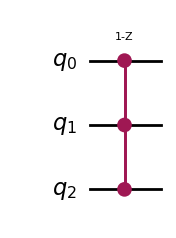

In [23]:
mcmt_ex = QuantumCircuit(3)
mcmt_ex.compose(MCMTGate(ZGate(), 3 - 1, 1), inplace=True)
mcmt_ex.draw(output="mpl", style="iqp")

Note that many qubits may be involved in the control process (here three qubits are), but no single qubit is denoted as a target. This is because the entire state gets an overall "-" sign (phase flip); the gate affects all the qubits equivalently. This is different from many other multiple qubit gates, like the `CX` gate which has a single control qubit and a single target qubit.

In the following code, we define a phase query gate (or oracle) that does what we just described above: marks one or more input basis states defined through their bit-string representation. The MCMT gate is used to implement the multi-controlled Z-gate.

In [12]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [
            ind for ind in range(num_qubits) if rev_target.startswith("0", ind)
        ]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

Now we choose a specific "marked" state to be our target, and apply the function we just defined. Let's see what kind of circuit it created.

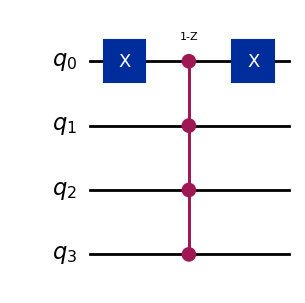

In [13]:
marked_states = ["1110"]
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

If qubits 1-3 are in the $|1\rangle$ state, and qubit 0 is initially in the $|0\rangle$ state, the first X gate will flip qubit 0 to $|1\rangle$ and all qubits will be in $|1\rangle.$ This means the MCMT gate will apply an overall sign change or phase flip, as desired. For any other case, either qubits 1-3 are in the $|0\rangle$ state, or qubit 0 is flipped to the $|0\rangle$ state, and the phase flip will not be applied. So we see that this circuit does indeed mark our desired state $|0111\rangle,$ or the bitstring `{1110}`.

The full Grover operator consists of the phase query gate (oracle), Hadamard layers, and also the $Z_\text{OR}$ operator. We can use the built-in `grover_operator` to construct this from the oracle we defined above.

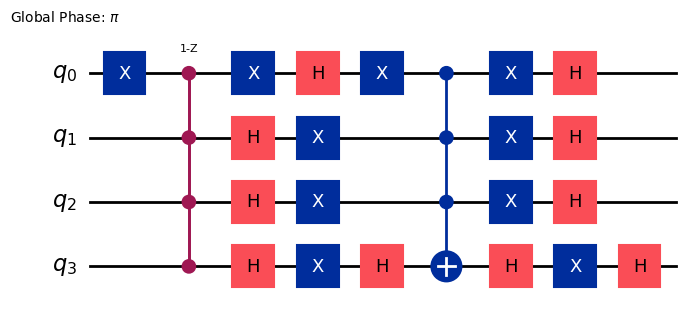

In [14]:
grover_op = grover_operator(oracle)
grover_op.decompose(reps=0).draw(output="mpl", style="iqp")

As we argued above, we may need to apply the Grover operator multiple times. The optimal number of iterations, $t,$ to maximize the amplitude of the target state in the absence of noise can be obtained from this expression:
$$
(2t+1)\theta = (2t+1)\sin^{-1}\left( \sqrt{\frac{|A_1|}{N}}\right) \approx (2t+1)\sqrt{\frac{|A_1|}{N}} \approx \frac{\pi}{2}\\
t\approx \frac{\pi}{4} \sqrt{\frac{N}{|A_1|}}-\frac{1}{2}
$$
Here $A_1$ is the number of solutions or target states. On modern noisy quantum computers, the experimentally optimal nubmer of iterations might be different. But here we calculate and use this theoretical, optimal number using $A_1=1$.

In [ ]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
print(optimal_num_iterations)

3


Let us now construct a circuit that includes the initial Hadamard gates to create a superposition of all possible states, and the Grover operator applied the optimal number of times.

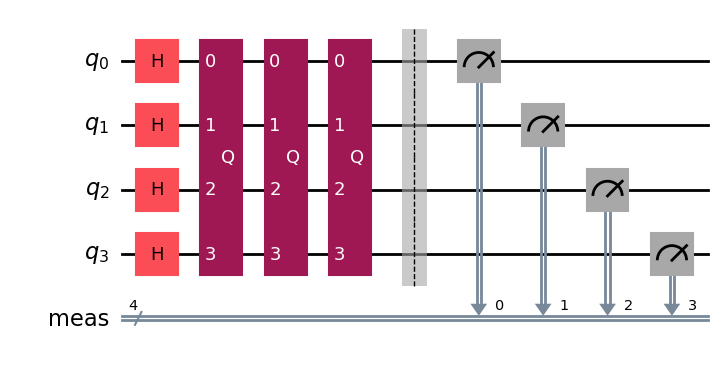

In [16]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

We have constructed our Grover circuit!

## Step 2: Optimize problem for quantum hardware execution

We have defined our abstract quantum circuit, but we need to rewrite it in terms of gates that are native to the quantum computer we actually want to use. We also need to specify which qubits on the quantum computer should be used. For these reasons and others we now must transpile our circuit. First, let us specify the quantum computer we wish to use.

There is code below for saving your credentials upon first use. Be sure to delete this information from the notebook after saving it to your environment, so that your credentials are not accidentally shared when you share the notebook. See [Set up your IBM Cloud account](/docs/guides/cloud-setup#3-connect-qiskit-with-your-service-instance) and [Initialize the service in an untrusted environment](/docs/guides/cloud-setup-untrusted) for more guidance.

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService

# Syntax for first saving your token.  Delete these lines after saving your credentials.
# QiskitRuntimeService.save_account(channel='ibm_quantum_platform', instance = '<MY_IBM_INSTANCE_CRN>', token='<MY_IBM_QUANTUM_TOKEN>', overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum_platform')

# Load saved credentials
service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)
backend.name

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-08 14:14:19,931: Default instance not set. Searching all available instances.


'ibm_brisbane'

Now we use a preset pass manager to optimize our quantum circuit for the backend we selected.

In [171]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
# The transpiled circuit will be very large. Only draw it if you are really curious.
# circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

It is worth noting at this time that the depth of the transpiled quantum circuit is substantial.

In [172]:
print("The total depth is ", circuit_isa.depth())
print(
    "The depth of two-qubit gates is ",
    circuit_isa.depth(lambda instruction: instruction.operation.num_qubits == 2),
)

The total depth is  439
The depth of two-qubit gates is  113


These are actually quite large numbers, even for this simple case. Since all quantum gates (and especially two-qubit gates) experience errors and are subject to noise, a series of over 100 two-qubit gates would result in nothing but noise if the qubits were not extremely high-performing. Let's see how these perform.

## Execute using Qiskit primitives

We want to make many measurements and see which state is the most likely. Such an amplitude amplification is a sampling problem that is suitable for execution with the `Sampler` runtime primitive.

Note that the run() method of Qiskit Runtime SamplerV2 takes an iterable of primitive unified blocks (PUBs). For sampler, each PUB is an iterable in the format (circuit, parameter_values). However, at a minimum, it takes a list of quantum circuit(s).

In [96]:
# To run on a real quantum computer (this was tested on ibm_torino and used 4 sec. of QPU time)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

To get the most out of this experience, we highly recommend you run your experiments on the real quantum computers available from IBM Quantum. But if you have exhausted your QPU time, you may uncomment the lines below to complete this activity using a simulator.

In [ ]:
# To run on local simulator:
# from qiskit.primitives import StatevectorSampler as Sampler
# sampler = Sampler()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

## Step 4: Post-process and return result in desired classical format

Now we can plot the results of our sampling in a histogram.

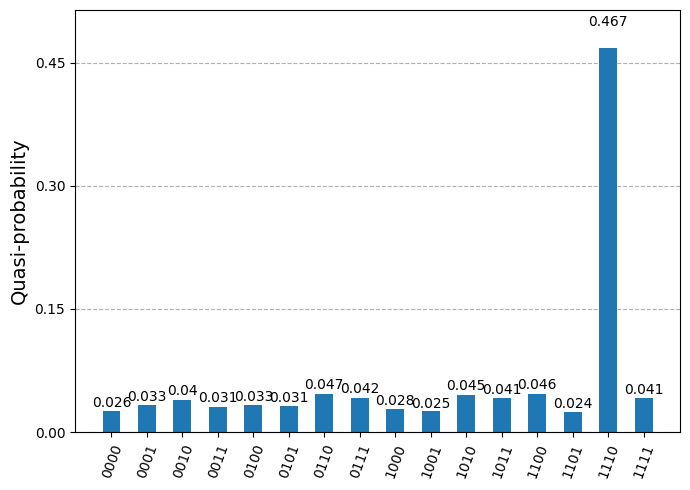

In [97]:
plot_distribution(dist)

We see that Grover's algorithm returned the desired state with the highest probability by far, at least an order of magnitude higher than other options. In the next activity, we will use the algorithm in a way that is more consistent with the two-party workflow of a query algorithm.

#### Check your understanding
Read the questions below, think about your answer, then click the triangle to reveal the solution.

<details>
<summary>

We just searched for a single solution in a set of $2^4=16$ possible states. We determined the optimal number of repetitions of the Grover operator to be $t=3$. Would this optimal number have increased or decreased if we had searched for (a) any of several solutions, or (b) a single solution in a space of more possible states?

</summary>

__Answer:__

Recall that as long as the number of solutions is small compared to the entire space of solutions, we can expand the sine function around small angles and use
$$
(2t+1)\theta = (2t+1) \sin^{-1}{\sqrt{\frac{|\mathcal{A}_1|}{N}}}\approx (2t+1) \sqrt{\frac{|\mathcal{A}_1|}{N}} \approx \pi/2\\

t \approx \frac{\pi}{4}\sqrt{\frac{N}{|\mathcal{A}_1|}}-\frac{1}{2}
$$

(a) We see from the above expression that increasing the number of solution states would decrease the number of iterations. Provided that the fraction $\frac{|\mathcal{A}_1|}{N}$ is still small, we can describe how $t$ would decrease: $t~\frac{1}{\sqrt{|\mathcal{A}_1|}}.$

(b) As the space of possible solutions ($N$) increases, the number of required iterations increases, but only like $t~\sqrt{N}$.

</details>

<details>
<summary>

Suppose we could increase the size of the target bitstring to be arbitrarily long and still have the outcome that the target state has a probability amplitude that is at least an order of magnitude larger than any other state. Does this mean we could use Grover's algorithm to reliably find the target state?

</summary>

__Answer:__

No. Suppose we repeated the first activity with 20 qubits, and we run the quantum circuit a number of times `num_shots = 10,000`. A uniform probability distribution would mean that every state has a probability of $10,000/2^{20}=0.00954$ of being measured even a single time. If the probability of measuring the target state were 10 times that of non-solutions (and the probability of each non-solution were correspondingly slightly decreased) there would only be about a 10% chance of measuring the target state even once. It would be highly unlikely to measure the target state multiple times, which would make it indistinguishable from the many randomly-obtained non-solution states. The good news is that we can obtain even higher-fidelity results by using error suppression and mitigation.

</details>


# Activity 2: An accurate query algorithm workflow

We will start this activity exactly as the first one, except that now you will pair up with another Qiskit enthusiast. You will pick a secret bitstring, and your parter will pick a (generally) different bitstring. You will each generate a quantum circuit that functions as an oracle, and you will exchange them. You will then use Grover's algorithm with that oracle to determine your partner's secret bitstring.

## Step 1: Map classical inputs to a quantum problem

Using the `grover_oracle` function defined above, construct an oracle circuit for one or more marked states. Make sure you tell your partner how many states you have marked, so they can apply the Grover operator the optimal number of times. **Don't make your bitstring too long. 3-5 bits should work without much difficulty.** Longer bitstrings would result in deep circuits that require more advanced techniques like error mitigation.

In [173]:
# Modify the marked states to mark those you wish to target.
marked_states = ["1000"]
oracle = grover_oracle(marked_states)

Now you have created a quantum circuit that flips the phase of your target state. You can save this circuit as `my_circuit.qpy` using the syntax below.

In [ ]:
from qiskit import qpy

# Save to a QPY file at a location where you can easily find it.
# You might want to specify a global address.
with open("C:\\Users\\...put your own address here...\\my_circuit.qpy", "wb") as f:
    qpy.dump(oracle, f)

Now send this file to your partner (via email, messaging service, a shared repo, etc.). Have your partner send you their circuit as well. Make sure you save the file somewhere you can easily find it. Once you have your partner's circuit you could visualize it. But that breaks the query model. That is, we're modeling a situation in which you can query the oracle (use the oracle circuit) but not examine it to determine what state it targets.

In [ ]:
from qiskit import qpy

# Load the circuit from your partner's qpy file from the folder where you saved it.
with open("C:\\Users\\...file location here...\\my_circuit.qpy", "rb") as f:
    circuits = qpy.load(f)

# qpy.load always returns a list of circuits
oracle_partner = circuits[0]

# You could visualize the circuit, but this would break the model of a query algorithm.
# oracle_partner.draw("mpl")

Ask your partner how many target states they encoded and enter it below.

In [174]:
# Update according to your partner's number of target states.
num_marked_states = 1

This is used in the next expression to determine the optimal number of Grover iterations.

In [175]:
grover_op = grover_operator(oracle_partner)
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(num_marked_states / 2**grover_op.num_qubits)))
)
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()

## Step 2: Optimize problem for quantum hardware execution

This proceeds exactly as before.

In [176]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
backend.name

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_partner_isa = pm.run(qc)

## Step 3: Execute using Qiskit primitives

This is also identical to the process in the first activity.

In [ ]:
# To run on a real quantum computer (this was tested on ibm_torino and used 4 sec. of QPU time)

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_partner_isa]).result()
dist = result[0].data.meas.get_counts()

## Step 4: Post-process and return result in desired classical format

Now display a histogram of your sampling results. One or more states should have much higher measurement probability than the others. Report these to your partner and check if you correctly determined the target states. By default, the histogram displayed is of the same circuit from the first activity. You should obtain different results from your partner's circuit.

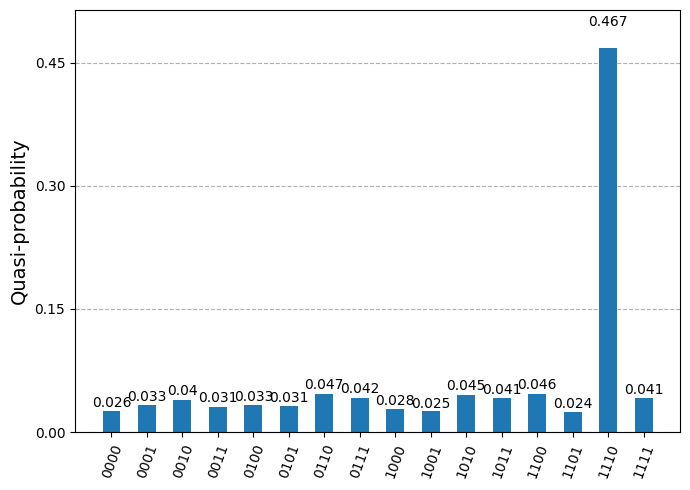

In [114]:
plot_distribution(dist)

#### Check your understanding
Read the questions or prompts below, think about your answer or talk through the process with your partner. Click the triangle for hints or suggestions.

<details>
<summary>

You should have correctly obtained your partner's target state(s). If you did not, work with your partner to identify what went wrong. Click below for a few ideas.

</summary>

__Hints:__

* Visualize/draw your partner's circuit and make sure it loaded correctly.
* Compare the circuits used and compare the expected outcome to that which you obtained.
* Check the depth of the circuits used to make sure the bitstring wasn't too long or the number of Grover iterations prohibitively high.

</details>

<details>
<summary>

If you haven't already, draw the oracle circuit your partner sent you. See if you can talk through the effect of each gate and argue what the target state must have been. This will be much easier for the case of a single marked state than for multiple.

</summary>

__Hints:__

* Recall that the job of the oracle is to flip the sign on the target state.
* Recall that the MCMTGate flips the sign on a state if and only if all qubits involved in the control are in the $|1\rangle$ state.
* If you target state will already have a $|1\rangle$ on a particular qubit, then you need not do anything to that qubit. If your target has a $|0\rangle$ on a particular qubit and you want the MCMTGate to flip the sign, you need to apply an `X` gate to that qubit in your oracle (and then undo the `X` gate after the MCMTGate).

</details>

<details>
<summary>

Repeat the experiment with one fewer iteration of the Grover operator. Do you still obtain the correct answer? Why or why not?

</summary>

__Guidance:__

You probably will, though it might depend on the number of solutions encoded. This highlights a subtlety: the "optimal" number of Grover iterations is the number that makes the probability of measuring the marked state as high as possible. But fewer iterations than that may still make the marked state substantially more likely than other states. So you may be able to get away with fewer iterations than the optimal number. This reduces circuit depth, and thus reduces error rates.

</details>


<details>
<summary>

Why might someone want to use fewer Grover iterations than the "optimal number" identified here?

</summary>

__Answer:__

The "optimal" number of Grover iterations is the number that makes the probability of measuring the marked state as high as possible in the absence of noise. But fewer iterations than that may still make the marked state substantially more likely than other states. So you may be able to get away with fewer iterations than the optimal number. This reduces circuit depth, and thus reduces error rates.

</details>

## Activity 3: Criterion other than a specific bitstring

As a final illustration of how Grover's algorithm might be useful in the context of a subroutine, let us imagine that we need quantum states with a certain number of `1`s in the bitstring representation. This is common in situations where conservation laws are involved. For example, in the context of quantum chemistry, one often maps a `1` state of a qubit to an occupation of an electronic orbital. In order for charge to be conserved, the total number of `1`s must also stay constant. Constraints like this are so common they have a special name: **Hamming weight constraints** and the number of `1`s in the state is called the **Hamming weight**.

## Step 1:

Let us first write a function that marks states with the desired Hamming weight. We will write this in general for an unspecified number of qubits `num_qubits` and target Hamming weight `target_weight`.

In [ ]:
from qiskit import QuantumCircuit


def grover_oracle_hamming_weight(num_qubits, target_weight):
    """
    Build a Grover oracle that marks all states with Hamming weight == target_weight.

    Parameters:
        num_qubits (int): Number of qubits in the circuit.
        target_weight (int): The Hamming weight to mark.

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle.
    """
    qc = QuantumCircuit(num_qubits)
    marked_count = 0
    marked_list = []
    for x in range(2**num_qubits):
        bitstr = format(x, f"0{num_qubits}b")
        if bitstr.count("1") == target_weight:
            # Count the number of target states
            marked_count = marked_count + 1
            marked_list.append(bitstr)
            # Reverse for Qiskit bit order (qubit 0 is rightmost)
            rev_target = bitstr[::-1]
            zero_inds = [i for i, b in enumerate(rev_target) if b == "0"]
            # Apply X gates to 'open' controls (where bit is 0)
            qc.x(zero_inds)
            # Multi-controlled Z (as MCX conjugated by H)
            if num_qubits == 1:
                qc.z(0)
            else:
                qc.h(num_qubits - 1)
                qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
                qc.h(num_qubits - 1)
            # Undo X gates
            qc.x(zero_inds)
    return qc, marked_count, marked_list

['011', '101', '110']


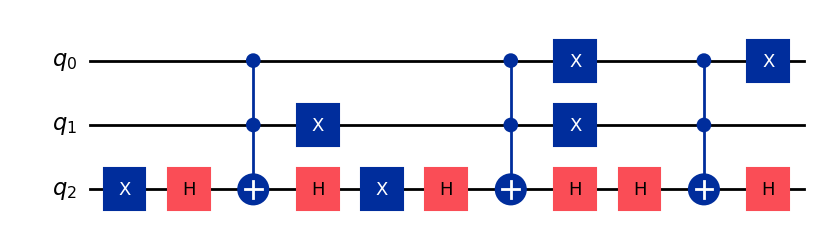

In [20]:
# Completing step 1
oracle, num_marked_states, marked_states = grover_oracle_hamming_weight(3, 2)
print(marked_states)
oracle.draw(output="mpl", style="iqp")

From here the entire process is identical to that from the previous two activities. For brevity the Qiskit patterns steps are shown only in code comments here.

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Completing step 1
oracle, num_marked_states, marked_states = grover_oracle_hamming_weight(4, 2)
oracle.draw(output="mpl", style="iqp")

grover_op = grover_operator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

# Step 2: Optimize for running on real quantum computers

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_isa = pm.run(qc)

# Step 3: Execute using Qiskit primitives
# To run on a real quantum computer (this was tested on ibm_torino and used 4 sec. of QPU time)

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

# To run on local simulator:
# from qiskit.primitives import StatevectorSampler as Sampler
# sampler = Sampler()
# result = sampler.run([qc]).result()
# dist = result[0].data.meas.get_counts()

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-08 14:14:51,686: Default instance not set. Searching all available instances.


ibm_brisbane


In [ ]:
print("The total depth is ", circuit_isa.depth())
print(
    "The depth of two-qubit gates is ",
    circuit_isa.depth(lambda instruction: instruction.operation.num_qubits == 2),
)

The total depth is  502
The depth of two-qubit gates is  130


In [ ]:
num_marked_states

6

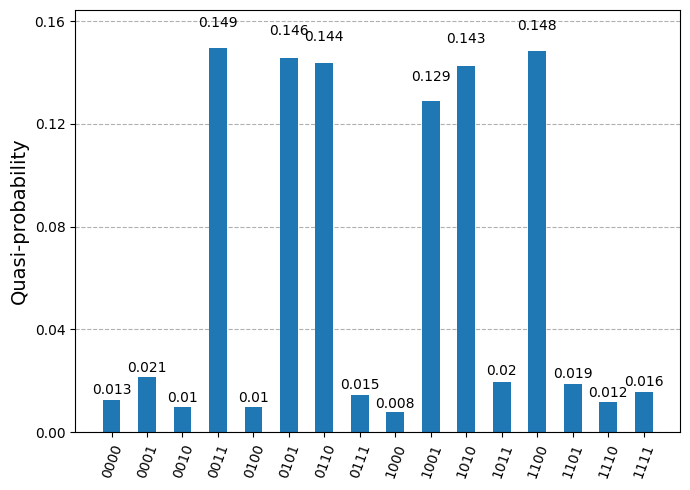

In [ ]:
plot_distribution(dist)

Here Grover's algorithm did indeed prepare the states with Hamming weight 2 to be much more likely to be measured than any other states, roughly one order of magnitude more likely.

### Critical concepts:

In this module, we learned some key features of Grover's algorithm:
- Whereas classical unstructured search algorithms require a number of queries that scales linearly in the size of the space, $N,$ Grover's algorthm requires a number of queries that scales like $\sqrt{N}.$
- Grover's algorithm involves repeating a series of operations (commonly called the "Grover operator") a number of times $t,$ chosen to make the target states optimally likely to be measured.
- Grover's algorithm can be run with fewer than $t$ iterations and still amplify the target states.
- Grover's algorithm fits into the query model of computation and makes the most sense when one person controls the search and another controls/constructs the oracle. It may also be useful as a subroutine in other quantum computations.

## Questions

### T/F questions:

1. T/F Grover's algorthm provides an exponential improvement over classical algorithms in the number of queries needed to find a single marked state in unstructured search.

2. T/F Grover's algorithm works by iteratively increasing the probability that a solution state will be measured.

3. T/F The more times you iterate the Grover operator the higher the probability of measuring a solution state.

### MC questions:

1. Select the best option to complete the sentence. The best strategy to successfully use Grover's algorithm on modern quantum computers is to iterate the Grover operator...
- a. Only once.
- b. Always $t$ times, to maximize the solution state(s)' probability amplitude.
- c. Up to $t$ times, though fewer may be enough to make solution states stand out.
- d. No fewer than 10 times.


2. An phase query circuit is shown here that functions as an oracle to mark a certain state with a phase flip. Which of the following states get marked by this circuit?

![An image of a simple grover oracle.](/learning/images/modules/computer-science/grovers/grover-oracle-question.avif)

- a. $|0000\rangle$
- b. $|0101\rangle$
- c. $|0110\rangle$
- d. $|1001\rangle$
- e. $|1010\rangle$
- f. $|1111\rangle$


3. Suppose you want to search for 3 marked states from a set of 128. What is the optimal number of iterations of the Grover operator to maximize the amplitudes of the marked states?
- a. 1
- b. 3
- c. 5
- d. 6
- e. 20
- f. 33


### Discussion questions:

1. What other conditions might you use in a quantum oracle? Consider conditions that are easy to state or impose on a bitstring but are not merely writing out the marked bitstrings?


2. Can you see any problems with scaling Grover's algorithm on modern quantum computers?